<a href="https://colab.research.google.com/github/xslittlemaggie/Tencent_Education_Deep_Learning_Course/blob/master/airline_passengers_prediction_Time_Series_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [0]:
import pandas as pd
import numpy as np
import time
import os
# visualization
import matplotlib.pyplot as plt

# model building
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import adam
from keras.layers import LSTM, SimpleRNN


# 1. 数据导入， 输入处理

## 读取数据

In [0]:
data = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

In [68]:
data.head(10)

,num,weekday,hour
0,0,5,17
1,1,5,17
2,1,5,17
3,2,5,17
4,4,5,17
5,5,5,17
6,5,5,17
7,5,5,17
8,4,5,17
9,3,5,17


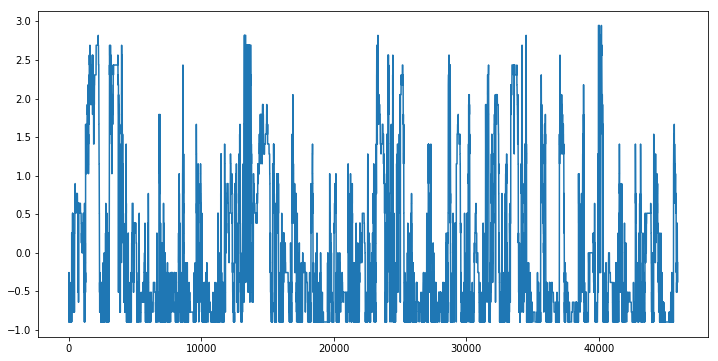

In [113]:
plt.figure(figsize = (12, 6))
plt.plot(data["num"])
plt.show()

### 特征变量：
- num: 自行车数量
- weekday: 星期
- hour: 小时

总共**45949** 条数据

这些数据是按照一分钟一分钟的顺序排列的。

就是用前面的时间的车的数量，预测后面一分钟车的数量
例如， 用前面9分钟的车的数量，预测第十分钟会有多少量车

## 数据预处理
- 归一化
- 标准化

我们用前面1-t时刻的数据，预测第 t + 1 时刻会有多少辆车

In [0]:
# normalize the dataset

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data)

In [75]:
data.columns = ["num", "hour", "week"]
data.head()

,num,hour,week
0,-0.896306,1.002493,0.794829
1,-0.768196,1.002493,0.794829
2,-0.768196,1.002493,0.794829
3,-0.640086,1.002493,0.794829
4,-0.383867,1.002493,0.794829


In [0]:
sequence_length = 10

result = []
for index in range(len(data) - sequence_length):
  result.append(data["num"][index: index + sequence_length])
result = np.array(result).astype("float64")

In [77]:
result.shape

(45939, 10)

## 训练集, 测试集划分

我们选了10%的数据作为测试，90%的数据进行训练。每个10长度的序列的最后一个值作为目标值，其余前面的部分作为输入值。输入值输入到模型，目标值是真实值，也就是模型想要达到的目标。

In [0]:
row = int(round(0.9 * result.shape[0]))   #90% 作为训练数据， 10% 作为测试数据
train = result[:row, :]
np.random.shuffle(train)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = result[row:, :-1]
y_test = result[row:, -1]

### 输入数据：
输入必须是三维的

- 样本个数
- 时间步长
- 特征个数


In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # 输入必须是三维的， 样本个数， 时间步长， 特征个数
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [80]:
print("X_train: ", X_train.shape)
print("Y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("Y_test: ", y_test.shape)

X_train:  (41345, 9, 1)
Y_train:  (41345,)
X_test:  (4594, 9, 1)
Y_test:  (4594,)


# 2. 模型建立，训练

## 建立简单SimpleRNN模型

In [81]:
model = Sequential()

# 第一层
model.add(SimpleRNN(
                    50, # 第一层的输出
                    input_shape = (None, 1), # 输入是一维度， 所以为1
                    return_sequences = False   # 最后一层用False
))  
model.add(Dropout(0.2))

# 第二层, 用Dense, 上一层的输出结果全部乘以一个矩阵， 最终得到一个数。
model.add(Dense(1)) # 期望输出的数的个数,我们的输出是一个数
model.add(Activation("linear"))
model.compile(loss = "mse", optimizer = "rmsprop") # 线性回归问题用 rmsprop
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


### 第一组权重

In [82]:
# x * W
model.get_weights()[0].shape

(1, 50)

### 第二组权重

In [83]:
# s * U 
model.get_weights()[1].shape

(50, 50)

### 第三组权重

In [84]:
# bias
model.get_weights()[2].shape

(50,)

### 第四组权重

In [85]:
model.get_weights()[3].shape

(50, 1)

### 第五组权重

In [86]:
model.get_weights()[4]

array([0.], dtype=float32)

### 模型训练

In [87]:
epochs = 200
history_0 = model.fit(X_train, y_train,
         batch_size = 512, 
         epochs = epochs, 
         validation_split = 0.05)

Train on 39277 samples, validate on 2068 samples
Epoch 1/200
39277/39277 [==============================] - 1s 27us/step - loss: 0.2554 - val_loss: 0.0352
Epoch 2/200
39277/39277 [==============================] - 1s 18us/step - loss: 0.0450 - val_loss: 0.0228
Epoch 3/200
39277/39277 [==============================] - 1s 16us/step - loss: 0.0326 - val_loss: 0.0184
Epoch 4/200
39277/39277 [==============================] - 1s 17us/step - loss: 0.0278 - val_loss: 0.0190
Epoch 5/200
39277/39277 [==============================] - 1s 16us/step - loss: 0.0263 - val_loss: 0.0178
Epoch 6/200
39277/39277 [==============================] - 1s 18us/step - loss: 0.0246 - val_loss: 0.0182
Epoch 7/200
39277/39277 [==============================] - 1s 16us/step - loss: 0.0246 - val_loss: 0.0169
Epoch 8/200
39277/39277 [==============================] - 1s 17us/step - loss: 0.0240 - val_loss: 0.0178
Epoch 9/200
39277/39277 [==============================] - 1s 16us/step - loss: 0.0240 - val_loss: 0.01

In [88]:
min(history_0.history["val_loss"])

0.016219488701763304

### 模型评估

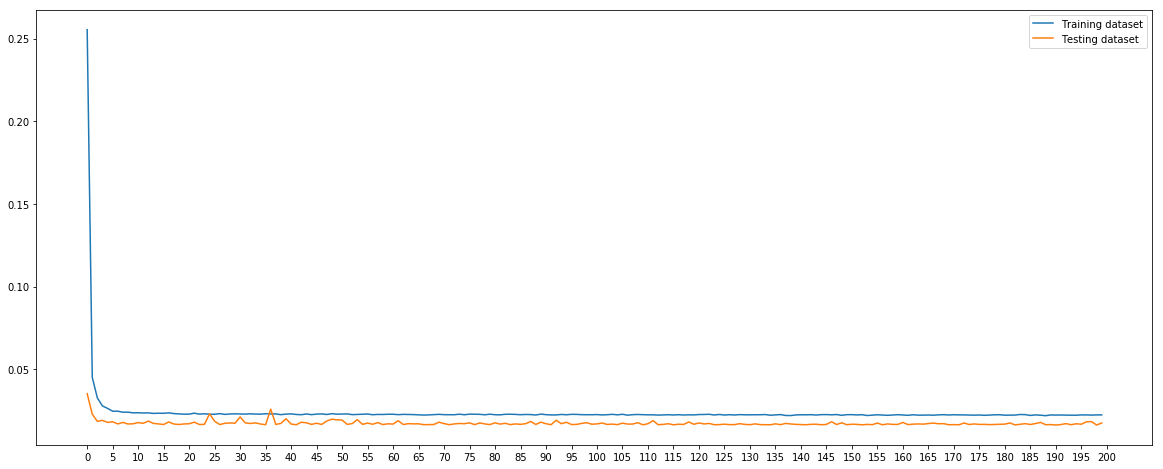

In [89]:
plt.figure(figsize = (20, 8))
plt.plot(history_0.history["loss"])
plt.plot(history_0.history["val_loss"])
plt.legend(["Training dataset", "Testing dataset"])
plt.xticks(range(0, epochs + 1, 5))
plt.show()

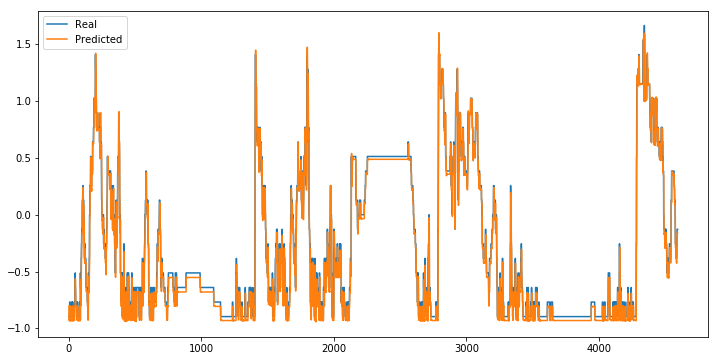

In [90]:
y_predicted_0 = model.predict(X_test)
y_predicted_0 = np.reshape(y_predicted_0, (y_predicted_0.size, ))

plt.figure(figsize = (12, 6))
plt.plot(y_test)
plt.plot(y_predicted_0)
plt.legend(["Real", "Predicted"])
plt.show()

## 单层LSTM

In [91]:
model = Sequential()

# 第一层
model.add(LSTM(50, # 第一层的输出
                    input_shape = (None, 1), # 输入是一维度， 所以为1
                    return_sequences = False   # 最后一层用False
))  
model.add(Dropout(0.2))

# 第二层, 用Dense, 上一层的输出结果全部乘以一个矩阵， 最终得到一个数。
model.add(Dense(1)) # 期望输出的数的个数,我们的输出是一个数
model.add(Activation("linear"))
model.compile(loss = "mse", optimizer = "rmsprop") # 线性回归问题用 rmsprop
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [92]:
history_1 = model.fit(X_train, y_train,
         batch_size = 512, 
         epochs = epochs, 
         validation_split = 0.05)

Train on 39277 samples, validate on 2068 samples
Epoch 1/200
39277/39277 [==============================] - 3s 65us/step - loss: 0.1900 - val_loss: 0.0394
Epoch 2/200
39277/39277 [==============================] - 2s 46us/step - loss: 0.0426 - val_loss: 0.0344
Epoch 3/200
39277/39277 [==============================] - 2s 43us/step - loss: 0.0348 - val_loss: 0.0241
Epoch 4/200
39277/39277 [==============================] - 2s 43us/step - loss: 0.0315 - val_loss: 0.0212
Epoch 5/200
39277/39277 [==============================] - 2s 45us/step - loss: 0.0289 - val_loss: 0.0205
Epoch 6/200
39277/39277 [==============================] - 2s 44us/step - loss: 0.0272 - val_loss: 0.0183
Epoch 7/200
39277/39277 [==============================] - 2s 44us/step - loss: 0.0258 - val_loss: 0.0205
Epoch 8/200
39277/39277 [==============================] - 2s 47us/step - loss: 0.0247 - val_loss: 0.0173
Epoch 9/200
39277/39277 [==============================] - 2s 43us/step - loss: 0.0237 - val_loss: 0.01

In [93]:
min(history_1.history["val_loss"])

0.014014386519703229

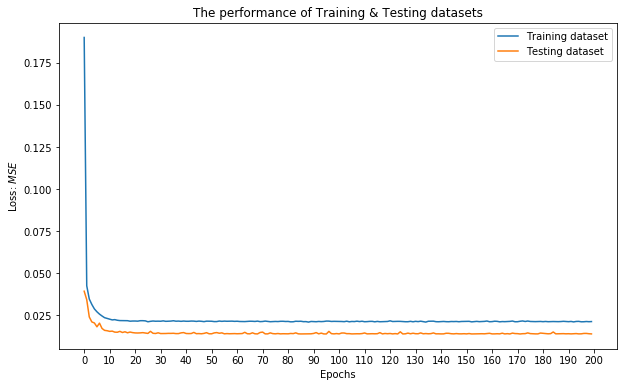

In [94]:
plt.figure(figsize = (10, 6))
plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.legend(["Training dataset", "Testing dataset"])
plt.xticks(range(0, epochs + 1, 10))
plt.ylabel("Loss: $MSE$")
plt.xlabel("Epochs")
plt.title("The performance of Training & Testing datasets")
plt.show()

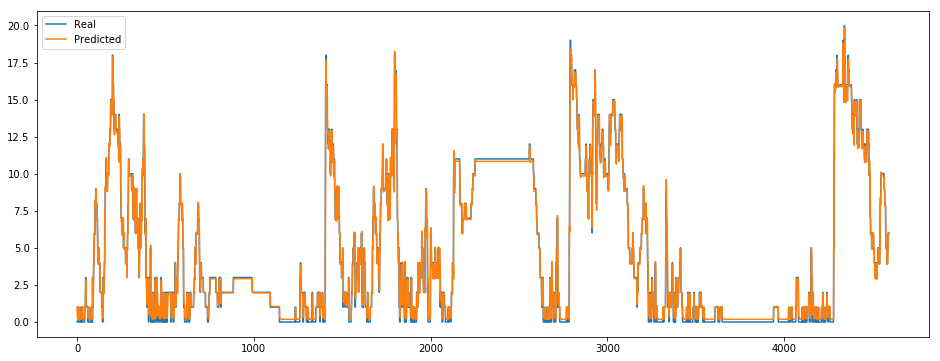

In [46]:
y_predicted_1 = model.predict(X_test)
y_predicted_1 = np.reshape(y_predicted_1, (y_predicted_1.size, ))

plt.figure(figsize = (16, 6))
plt.plot(y_test)
plt.plot(y_predicted_1)
plt.legend(["Real", "Predicted"])
#plt.xticks(range(0, epochs + 1, 5))
plt.show()

## 调参 1. 数据标准化（如上）

## 调参 2. 改变序列长度

In [0]:
sequence_length = 100

result_1 = []
for index in range(len(data) - sequence_length):
  result_1.append(data["num"][index: index + sequence_length])
result_1 = np.array(result_1).astype("float64")

row = int(round(0.9 * result_1.shape[0]))   #90% 作为训练数据， 10% 作为测试数据
train_1 = result_1[:row, :]
np.random.shuffle(train_1)
X_train_1 = train_1[:, :-1]
y_train_1 = train_1[:, -1]
X_test_1 = result_1[row:, :-1]
y_test_1 = result_1[row:, -1]

X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0], X_train_1.shape[1], 1))  # 输入必须是三维的， 样本个数， 时间步长， 特征个数
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], X_test_1.shape[1], 1))

In [110]:
print("X_train: ", X_train_1.shape)
print("Y_train: ", y_train_1.shape)
print("X_test: ", X_test_1.shape)
print("Y_test: ", y_test_1.shape)

X_train:  (41264, 99, 1)
Y_train:  (41264,)
X_test:  (4585, 99, 1)
Y_test:  (4585,)


In [111]:
model = Sequential()

# 第一层
model.add(LSTM(50, # 第一层的输出
                    input_shape = (None, 1), # 输入是一维度， 所以为1
                    return_sequences = False   # 最后一层用False
))  
model.add(Dropout(0.2))

# 第二层, 用Dense, 上一层的输出结果全部乘以一个矩阵， 最终得到一个数。
model.add(Dense(1)) # 期望输出的数的个数,我们的输出是一个数
model.add(Activation("linear"))
model.compile(loss = "mse", optimizer = "rmsprop") # 线性回归问题用 rmsprop
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [112]:
epochs = 30
history_2 = model.fit(train_1, y_train_1,
         batch_size = 512, 
         epochs = epochs, 
         validation_split = 0.05)

Train on 39277 samples, validate on 2068 samples
Epoch 1/50
39277/39277 [==============================] - 3s 85us/step - loss: 0.1540 - val_loss: 0.0394
Epoch 2/50
39277/39277 [==============================] - 2s 46us/step - loss: 0.0435 - val_loss: 0.0261
Epoch 3/50
39277/39277 [==============================] - 2s 46us/step - loss: 0.0359 - val_loss: 0.0235
Epoch 4/50
39277/39277 [==============================] - 2s 43us/step - loss: 0.0315 - val_loss: 0.0208
Epoch 5/50
39277/39277 [==============================] - 2s 45us/step - loss: 0.0290 - val_loss: 0.0193
Epoch 6/50
39277/39277 [==============================] - 2s 45us/step - loss: 0.0269 - val_loss: 0.0180
Epoch 7/50
39277/39277 [==============================] - 2s 45us/step - loss: 0.0255 - val_loss: 0.0172
Epoch 8/50
39277/39277 [==============================] - 2s 45us/step - loss: 0.0245 - val_loss: 0.0165
Epoch 9/50
39277/39277 [==============================] - 2s 50us/step - loss: 0.0238 - val_loss: 0.0166
Epoch 

In [114]:
min(history_2.history["val_loss"])

0.014155389193438239

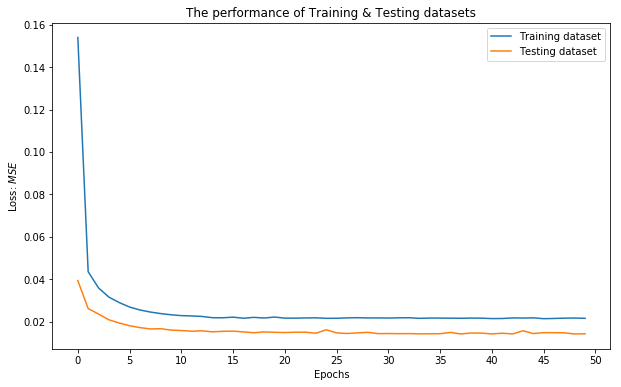

In [115]:
plt.figure(figsize = (10, 6))
plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.legend(["Training dataset", "Testing dataset"])
plt.xticks(range(0, epochs + 1, 5))
plt.ylabel("Loss: $MSE$")
plt.xlabel("Epochs")
plt.title("The performance of Training & Testing datasets")
plt.show()

## 调参 3. 加多模型深度

In [123]:
model = Sequential()

# 第一层
model.add(LSTM(
        50, # 我们输入的是一维的，所以定义输入的维度为1
        input_shape = (None, 1), # 这一层的输出数量
        return_sequences = True))
model.add(Dropout(0.2))

# 第二层
model.add(LSTM(100,
       return_sequences = False)) # 主要是多对一的关系，一般是最后一层
model.add(Dropout(0.2))

# 第三层， 最后一层用Dense,也就是上一层的输出结果全部都乘以一个举证，最终得到一个数。由于这里是进行线性回归操作，所以激活函数填linera
model.add(Dense(1)) # 期望的输出个数是layers[3]
        
model.add(Activation("linear"))

start = time.time()
model.compile(loss = "mse", optimizer = adam())  # rmsprop 线性回归问题的标准做法， ADAM（）
print("Compilation Time:", time.time() - start)

Compilation Time: 0.2711472511291504


In [124]:
epochs = 50
history_3 = model.fit(X_train, y_train,
         batch_size = 512, 
         epochs = epochs, 
         validation_split = 0.05)

Train on 39277 samples, validate on 2068 samples
Epoch 1/50
39277/39277 [==============================] - 7s 176us/step - loss: 0.1221 - val_loss: 0.0413
Epoch 2/50
39277/39277 [==============================] - 4s 91us/step - loss: 0.0503 - val_loss: 0.0349
Epoch 3/50
39277/39277 [==============================] - 4s 91us/step - loss: 0.0433 - val_loss: 0.0296
Epoch 4/50
39277/39277 [==============================] - 4s 90us/step - loss: 0.0393 - val_loss: 0.0273
Epoch 5/50
39277/39277 [==============================] - 4s 93us/step - loss: 0.0362 - val_loss: 0.0257
Epoch 6/50
39277/39277 [==============================] - 4s 96us/step - loss: 0.0333 - val_loss: 0.0238
Epoch 7/50
39277/39277 [==============================] - 4s 94us/step - loss: 0.0311 - val_loss: 0.0224
Epoch 8/50
39277/39277 [==============================] - 4s 94us/step - loss: 0.0293 - val_loss: 0.0208
Epoch 9/50
39277/39277 [==============================] - 4s 95us/step - loss: 0.0272 - val_loss: 0.0202
Epoch

In [125]:
min(history_3.history["val_loss"])

0.014038761764245983

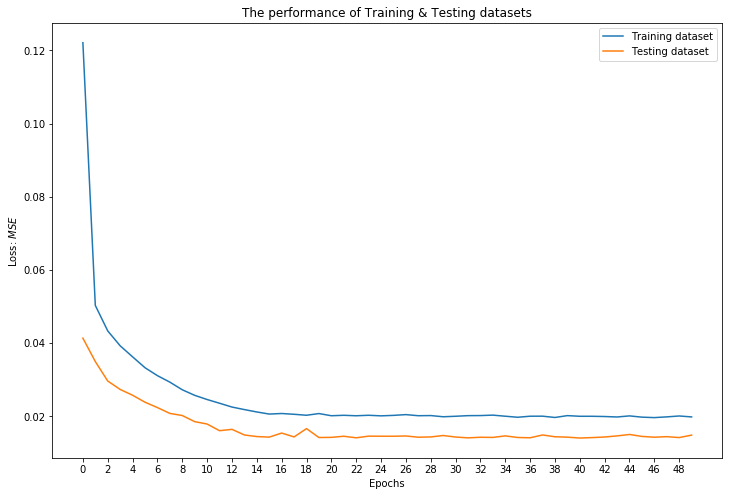

In [128]:
plt.figure(figsize = (12, 8))
plt.plot(history_3.history["loss"])
plt.plot(history_3.history["val_loss"])
plt.legend(["Training dataset", "Testing dataset"])
plt.xticks(range(0, epochs, 2))
plt.ylabel("Loss: $MSE$")
plt.xlabel("Epochs")
plt.title("The performance of Training & Testing datasets")
plt.show()

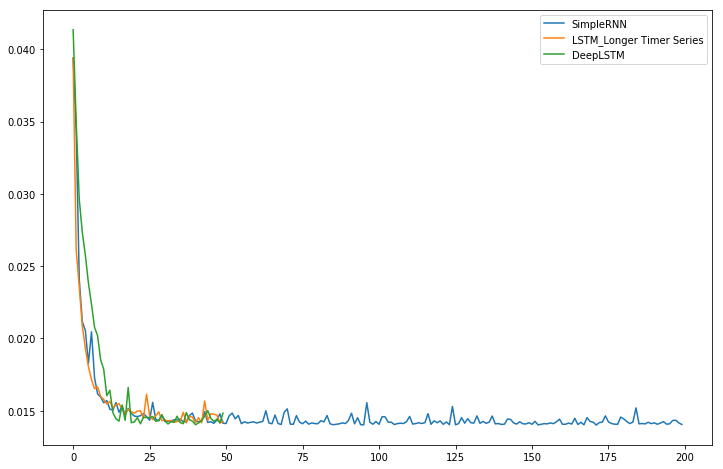

In [131]:
plt.figure(figsize = (12, 8))
plt.plot(history_1.history["val_loss"])
plt.plot(history_2.history["val_loss"])
plt.plot(history_3.history["val_loss"])
plt.legend(["SimpleRNN", "LSTM_Longer Timer Series", "DeepLSTM"])
plt.show()

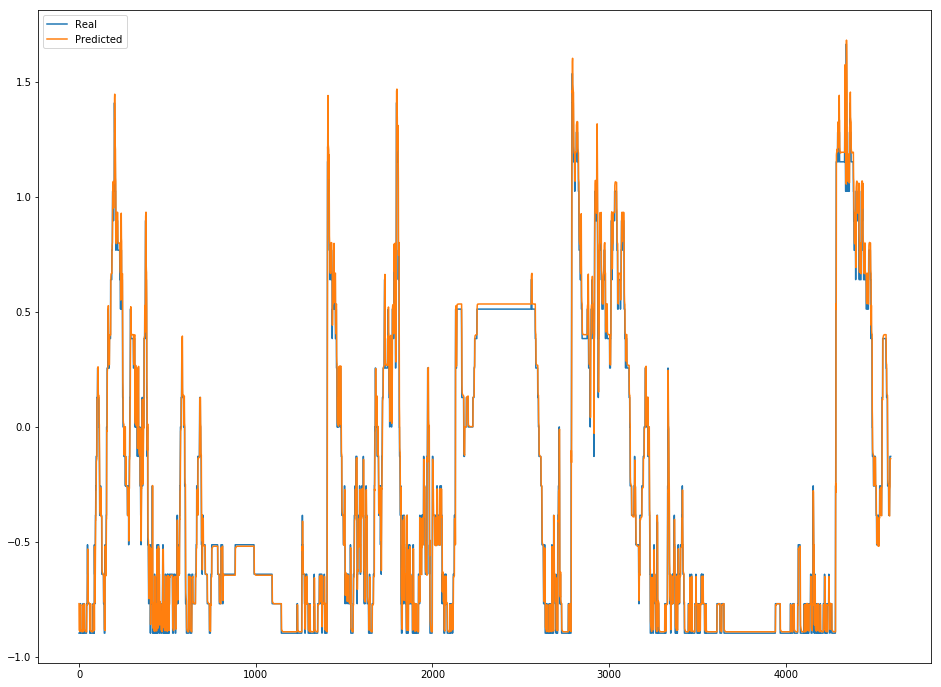

In [129]:
y_predicted_3 = model.predict(X_test)
y_predicted_3 = np.reshape(y_predicted_3, (y_predicted_3.size, ))

plt.figure(figsize = (16, 12))
plt.plot(y_test)
plt.plot(y_predicted_3)
plt.legend(["Real", "Predicted"])
plt.show()

## 权重初始化

## 调参 5: Batch size 512 --> 32

In [132]:
model = Sequential()

# 第一层
model.add(LSTM(
        50, # 我们输入的是一维的，所以定义输入的维度为1
        input_shape = (None, 1), # 这一层的输出数量
        return_sequences = True))
model.add(Dropout(0.2))

# 第二层
model.add(LSTM(100,
       return_sequences = False)) # 主要是多对一的关系，一般是最后一层
model.add(Dropout(0.2))

# 第三层， 最后一层用Dense,也就是上一层的输出结果全部都乘以一个举证，最终得到一个数。由于这里是进行线性回归操作，所以激活函数填linera
model.add(Dense(1)) # 期望的输出个数是layers[3]
        
model.add(Activation("linear"))

start = time.time()
model.compile(loss = "mse", optimizer = adam(), metrics = ["mse"])  # rmsprop 线性回归问题的标准做法， ADAM（）
print("Compilation Time:", time.time() - start)

Compilation Time: 0.042878150939941406


In [134]:
epochs = 50
history_5 = model.fit(X_train, y_train,
         batch_size = 32, 
         epochs = epochs, 
         validation_split = 0.05)
model.save(os.path.join("DATA","Test" + ".h5"))

Train on 39277 samples, validate on 2068 samples
Epoch 1/50
39277/39277 [==============================] - 50s 1ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0178 - val_mean_squared_error: 0.0178
Epoch 2/50
39277/39277 [==============================] - 48s 1ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 3/50
39277/39277 [==============================] - 49s 1ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 4/50
39277/39277 [==============================] - 49s 1ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 5/50
39277/39277 [==============================] - 49s 1ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 6/50
39277/39277 [==============================] - 48s 1ms/step - loss: 0.0223 - mean_squared_error: 0.0223 -

In [136]:
loss = model.evaluate(X_train, y_train)
print("Training loss: {}".format(loss))

loss = model.evaluate(X_test, y_test)
print("Testing loss: {}".format(loss))

41345/41345 [==============================] - 13s 310us/step
Training loss: [0.01603953560165748, 0.01603953560165748]
4594/4594 [==============================] - 2s 350us/step
Testing loss: [0.008472678064334506, 0.008472678064334506]


In [137]:
min(history_5.history["val_loss"])

0.013809143041388439

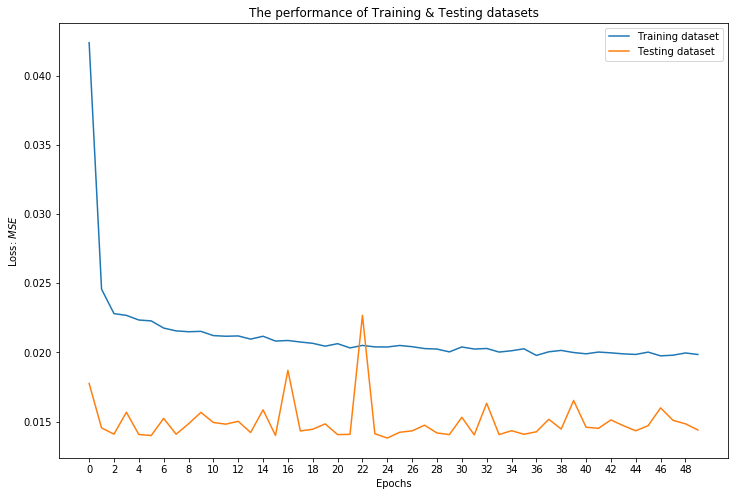

In [138]:
plt.figure(figsize = (12, 8))
plt.plot(history_5.history["loss"])
plt.plot(history_5.history["val_loss"])
plt.legend(["Training dataset", "Testing dataset"])
plt.xticks(range(0, epochs, 2))
plt.ylabel("Loss: $MSE$")
plt.xlabel("Epochs")
plt.title("The performance of Training & Testing datasets")
plt.show()

## 模型的不同性能评估

In [139]:
model = Sequential()

# 第一层
model.add(LSTM(
        50, # 我们输入的是一维的，所以定义输入的维度为1
        input_shape = (None, 1), # 这一层的输出数量
        return_sequences = True))
model.add(Dropout(0.2))

# 第二层
model.add(LSTM(100,
       return_sequences = False)) # 主要是多对一的关系，一般是最后一层
model.add(Dropout(0.2))

# 第三层， 最后一层用Dense,也就是上一层的输出结果全部都乘以一个举证，最终得到一个数。由于这里是进行线性回归操作，所以激活函数填linera
model.add(Dense(1)) # 期望的输出个数是layers[3]
        
model.add(Activation("linear"))
model.compile(loss = "mse", optimizer = adam(), metrics=['mse', 'mae', 'mape', 'cosine']) 
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, None, 50)          10400     
_________________________________________________________________
dropout_20 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_14 (Activation)   (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________

In [147]:
epochs = 50
history_6 = model.fit(X_train, y_train,
         batch_size = 512, 
         epochs = epochs, 
         validation_split = 0.05)
model.save('model_6.h5')  # creates a HDF5 file 'my_model.h5'

Train on 39277 samples, validate on 2068 samples
Epoch 1/50
39277/39277 [==============================] - 4s 92us/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.0784 - mean_absolute_percentage_error: 418.6972 - cosine_proximity: -0.9454 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0528 - val_mean_absolute_percentage_error: 396.3219 - val_cosine_proximity: -0.9642
Epoch 2/50
39277/39277 [==============================] - 3s 89us/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.0772 - mean_absolute_percentage_error: 409.1026 - cosine_proximity: -0.9431 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0583 - val_mean_absolute_percentage_error: 463.1842 - val_cosine_proximity: -0.9352
Epoch 3/50
39277/39277 [==============================] - 4s 89us/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.0783 - mean_absolute_percentage_error: 416.1187 -

In [0]:
#load model
#model = load_model('my_model.h5')

In [148]:
min(history_6.history["val_loss"])

0.013867061478905452

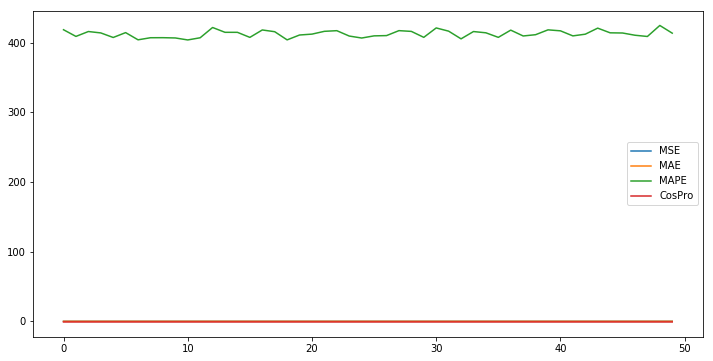

In [149]:
# plot metrics
plt.figure(figsize = (12, 6))
plt.plot(history_6.history['mean_squared_error'])
plt.plot(history_6.history['mean_absolute_error'])
plt.plot(history_6.history['mean_absolute_percentage_error'])
plt.plot(history_6.history['cosine_proximity'])
plt.legend(["MSE", "MAE", "MAPE", "CosPro"])
plt.show()

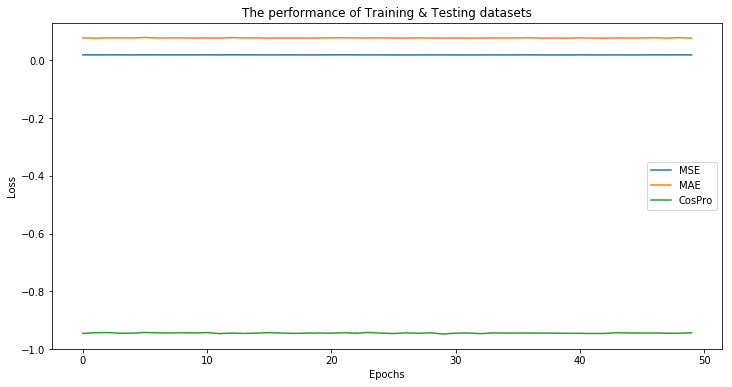

In [157]:
# plot metrics
plt.figure(figsize = (12, 6))
plt.plot(history_6.history['mean_squared_error'])
plt.plot(history_6.history['mean_absolute_error'])
plt.plot(history_6.history['cosine_proximity'])
plt.legend(["MSE", "MAE", "CosPro"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("The performance of Training & Testing datasets")
plt.show()

## 自定义模型

In [0]:
W = model.get_weights()[0]
U = model.get_weights()[1]
b = model.get_weights()[2]

def myRNN(n,X, W, U, b):
  "return Y"
  h = [[0], [0], [0]]
  Y = U * h + W * X + b
  return Y
  

In [0]:
h = np.array([[0], [0], [0]])
state = U.dot(h)

In [0]:
#W.dot(X)
X_ = X.reshape(X.shape[-1], 1)
prod = W.T.dot(X_)

In [0]:
b = model.get_weights()[2]

## self prediction

In [0]:
y_predicted = model.predict(X_test)

In [0]:
sequence_length = 99
auto_predict = [x for x in y_predicted]
for i in range(1000):
  temp = y_predicted[-99:]
  #print(temp)
  temp = np.reshape(temp, (1, 99, 1))
  res = model.predict(temp)
  auto_predict.append(res[0][0])
#auto_predict

In [0]:
auto_predicted = np.array(auto_predict)
auto_predicted = np.reshape(auto_predicted, (auto_predicted.size, ))

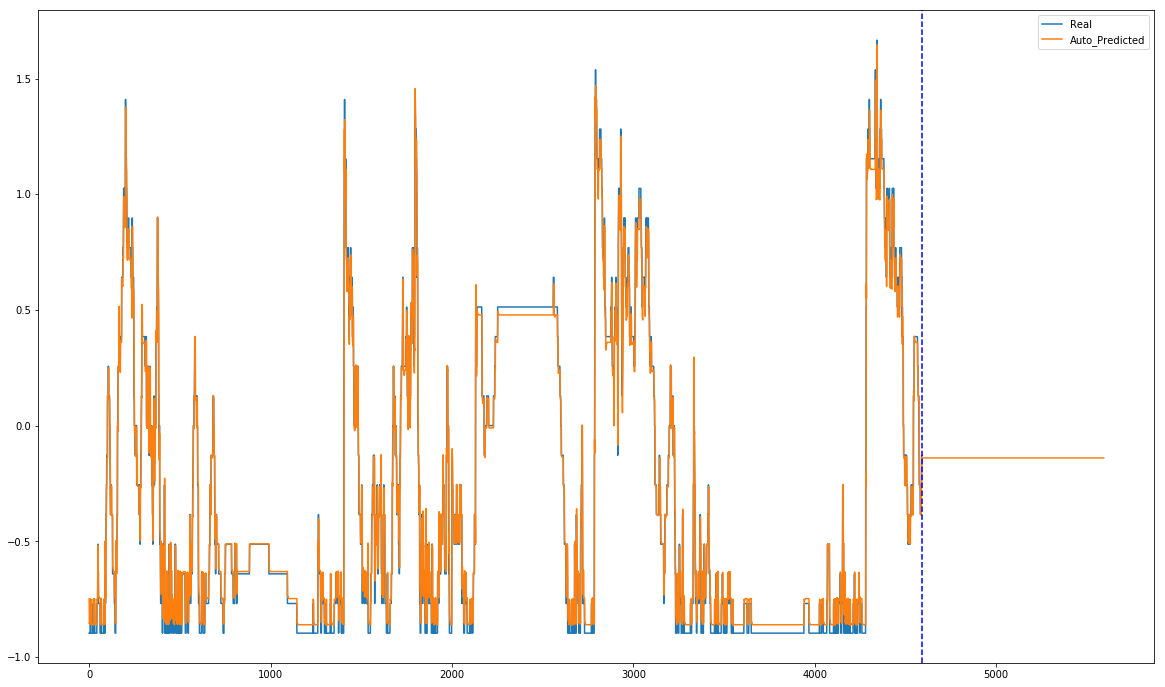

In [155]:
plt.figure(figsize = (20, 12))
plt.plot(y_test)
#plt.plot(y_predicted)
plt.plot(auto_predicted)
plt.legend(["Real", "Auto_Predicted"])
plt.axvline(x=4593, color='blue', linestyle='--')
plt.show()